In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# OCCUPATION_TYPE - ПРЕДСКАЗАТЬ

In [2]:
PATH = '../../raw_data/home-credit/'

In [3]:
description = pd.read_csv(PATH + 'HomeCredit_columns_description.csv', encoding_errors='ignore')

In [4]:
application_train_df = pd.read_csv(PATH + 'application_train.csv')
print('Training data shape: ', application_train_df.shape)

Training data shape:  (307511, 122)


In [92]:
def column_explain(column, df = application_train_df, left = -1, right = 50, step = 5):
    '''
    Выводит информацию о колонке, её описание,
    строит боксплот и показывает, какие значения
    принимает таргет в зависимости от значений в колонке
    df - датафрейм с признаками
    column - колонка, по которой хотим получить информацию
    left, right, step - границы интервала и шаг, по которому смотрим на фичи
    '''
    print(description.loc[description['Row'] == column]['Description'])
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=df[column])
    df['Column_check'] = pd.cut(df[column], list(range(left, right, step)))
    # Как ведет себя таргет в заисимости от значений признака
    print(df.groupby('Column_check')['TARGET'].agg(['mean','sem','count']))
    print("Nans count", df[column].isnull().sum())

In [5]:
def get_outliers_info(df, d = 1.5):
    """
    Статистика по наличию выбросов в признаках.
    df - датасет с признаками
    d - коэффициент, на который умножается IQR (обычно 1.5, что соотв. усам на boxplot)
    """
    df = df.copy()
    q75 = df.quantile(0.75)
    q25 = df.quantile(0.25)
    iqr = q75 - q25

    feature_list, outlier_list = [], []
    numerical_columns = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and df[c].nunique()>10]

    for feature in numerical_columns:
        lower_threshold = q25.loc[feature] - d*iqr[feature]
        upper_threshold = q75.loc[feature] + d*iqr[feature]
        
        df['is_outlier'] = np.nan
        df.loc[(df[feature] < lower_threshold) | (df[feature] > upper_threshold), 'is_outlier'] = 1
        df['is_outlier'] = df['is_outlier'].fillna(0)

        feature_list.append(feature)
        outlier_list.append(df['is_outlier'].mean())
        
    outliers_df = pd.DataFrame(index=feature_list, data=outlier_list, columns=['ratio_outliers'])
    outliers_df = outliers_df[outliers_df['ratio_outliers']>0]
    outliers_df = outliers_df.sort_values(by='ratio_outliers', ascending=False)
    
    return outliers_df

In [175]:
def fill_median(column, df = application_train_df):
    '''
    Заполняет наны столбца column медианой
    Если не получилось вернёт изначальный столбец
    '''
    df_median = df.copy()
    try:
        median = df_median.loc[df_median[column].notnull()][column].median()
        df_median[column] = df_median[column].fillna(median)
        return df_median[column]
    except:
        print('Ошибка')
        return df[column]

In [199]:
outliers_df = get_outliers_info(application_train_df)
outliers_df.head(40)

ratio_outliers
LIVINGAREA_AVG                      0.497833
LIVINGAREA_MEDI                     0.497803
LIVINGAREA_MODE                     0.497355
APARTMENTS_MEDI                     0.491244
APARTMENTS_AVG                      0.490815
APARTMENTS_MODE                     0.468042
YEARS_BEGINEXPLUATATION_MEDI        0.462231
YEARS_BEGINEXPLUATATION_AVG         0.461824
TOTALAREA_MODE                      0.461502
YEARS_BEGINEXPLUATATION_MODE        0.461320
NONLIVINGAREA_AVG                   0.446911
NONLIVINGAREA_MEDI                  0.446885
NONLIVINGAREA_MODE                  0.446657
EXT_SOURCE_1                        0.436183
BASEMENTAREA_AVG                    0.414564
BASEMENTAREA_MEDI                   0.414558
BASEMENTAREA_MODE                   0.414541
LANDAREA_MODE                       0.405927
LANDAREA_MEDI                       0.405901
LANDAREA_AVG                        0.405875
ENTRANCES_AVG                       0.385924
ENTRANCES_MEDI                      0.380955
ENTRANCES_MODE                      0.379310
YEARS_BUILD_MODE                    0.326811
YEARS_BUILD_MEDI                    0.326639
YEARS_BUILD_AVG                     0.326509
LIVINGAPARTMENTS_MODE               0.314857
LIVINGAPARTMENTS_MEDI               0.314418
LIVINGAPARTMENTS_AVG                0.307417
FLOORSMAX_AVG                       0.301179
COMMONAREA_MEDI                     0.301020
COMMONAREA_AVG                      0.300932
COMMONAREA_MODE                     0.300861
FLOORSMAX_MEDI                      0.295547
FLOORSMAX_MODE                      0.289229
FLOORSMIN_AVG                       0.214607
FLOORSMIN_MEDI                      0.211804
FLOORSMIN_MODE                      0.209638
ELEVATORS_AVG                       0.188292
ELEVATORS_MEDI                      0.184039

In [46]:
# Так можно посмотреть описание интересующего нас признака
description.loc[description['Row'] == 'AMT_REQ_CREDIT_BUREAU_QRT']['Description']

120    Number of enquiries to Credit Bureau about the...
Name: Description, dtype: object

<AxesSubplot:xlabel='DAYS_EMPLOYED'>

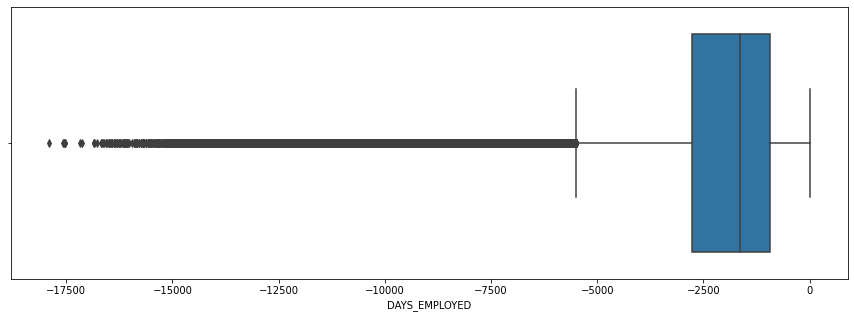

In [42]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=application_train_df['DAYS_EMPLOYED'])

In [43]:
#Рассмотрим на примере DAYS_EMPLOYED
application_train_df['DAYS_EMPLOYED_bin'] = pd.cut(application_train_df['DAYS_EMPLOYED'],
                                                   list(range(-10_000, 0, 1000)) + [0, 10e7])

In [44]:
# Как ведет себя таргет в заисимости от значений признака
application_train_df.groupby('DAYS_EMPLOYED_bin')['TARGET'].agg(['mean','sem','count'])

mean       sem   count
DAYS_EMPLOYED_bin                              
(-10000.0, -9000.0]  0.037255  0.004194    2040
(-9000.0, -8000.0]   0.049440  0.003936    3034
(-8000.0, -7000.0]   0.046966  0.003172    4450
(-7000.0, -6000.0]   0.048204  0.002878    5539
(-6000.0, -5000.0]   0.052275  0.002256    9737
(-5000.0, -4000.0]   0.056254  0.001910   14559
(-4000.0, -3000.0]   0.065012  0.001562   24903
(-3000.0, -2000.0]   0.074978  0.001338   38718
(-2000.0, -1000.0]   0.075937  0.000772  117848
(-1000.0, 0.0]       0.111522  0.001098   82136
(0.0, 100000000.0]        NaN       NaN       0

In [37]:
application_train_df.loc[application_train_df['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = np.nan

In [38]:
application_train_df['DAYS_EMPLOYED']

0         -637.0
1        -1188.0
2         -225.0
3        -3039.0
4        -3038.0
           ...  
307506    -236.0
307507   -1648.0
307508   -7921.0
307509   -4786.0
307510   -1262.0
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

In [15]:
def get_nan_info(df):
    """
    Статистика по наличию пропусков в признаках.
    df - датасет с признаками
    """
    df = df.copy()  
    nans_df = pd.DataFrame(df.isnull().sum().rename('n_nans'))
    
    N = df.shape[0]
    nans_df['ratio_nans'] = nans_df['n_nans']/N
    nans_df['ratio_nans'] = nans_df['ratio_nans'].round(2)
    
    nans_df = nans_df[nans_df['n_nans']>0]
    nans_df = nans_df.sort_values(by='n_nans', ascending=False)
    
    for feature in nans_df.index:
        nans_df.loc[feature, 'nan_target_mean'] = df[df[feature].isnull()]['TARGET'].mean()
        nans_df.loc[feature, 'not_nan_target_mean'] = df[df[feature].notnull()]['TARGET'].mean()
        
    return nans_df 

In [67]:
def make_nan(df, column, value):
    """
    Возвращает колонку, в которой значения больше value становятся nan
    df - датасет с признаками
    column - колонка, в которой нужно убрать признаки,
    которые больше, чем value
    """
    nan_df = df.copy()
    nan_df.loc[nan_df[column] > value, [column]] = np.nan
    return nan_df[column]

In [231]:
nans_df = get_nan_info(application_train_df)
nans_df

n_nans  ratio_nans  nan_target_mean  not_nan_target_mean
Column_check        60965        0.20         0.093119             0.077665
DAYS_EMPLOYED_bin    4547        0.01         0.036068             0.081399

In [191]:
nans_df

n_nans  ratio_nans  nan_target_mean  not_nan_target_mean
FONDKAPREMONT_MODE   210295        0.68         0.086188             0.068919
OWN_CAR_AGE          202929        0.66         0.085000             0.072441
WALLSMATERIAL_MODE   156341        0.51         0.091281             0.069815
HOUSETYPE_MODE       154297        0.50         0.091512             0.069870
EMERGENCYSTATE_MODE  145755        0.47         0.092607             0.070025
OCCUPATION_TYPE       96391        0.31         0.065131             0.087851
Column_check          60965        0.20         0.093119             0.077665
DAYS_EMPLOYED_bin      4547        0.01         0.036068             0.081399

In [18]:
# Вспомним про DAYS_EMPLOYED. Рассмотрим бывшие выборосы, которые мы заменили на NaN. Есть ли уже признак, которые поможет нам найти эти NaN?
# Да, оказывается, они соответствуют отсутствию работы, что 99% случаев происходит у пенсионеров. 
application_train_df[application_train_df['DAYS_EMPLOYED'].isnull()]['NAME_INCOME_TYPE'].value_counts(normalize=True)

Pensioner     0.999603
Unemployed    0.000397
Name: NAME_INCOME_TYPE, dtype: float64

In [16]:
application_train_df.groupby(['NAME_INCOME_TYPE'])['TARGET'].mean()

NAME_INCOME_TYPE
Businessman             0.000000
Commercial associate    0.074843
Maternity leave         0.400000
Pensioner               0.053864
State servant           0.057550
Student                 0.000000
Unemployed              0.363636
Working                 0.095885
Name: TARGET, dtype: float64

In [40]:
DAYS_EMPLOYED_median = application_train_df[application_train_df['DAYS_EMPLOYED'].notnull()]['DAYS_EMPLOYED'].median()
print(DAYS_EMPLOYED_median)
application_train_df['DAYS_EMPLOYED'] = application_train_df['DAYS_EMPLOYED'].fillna(DAYS_EMPLOYED_median)

-1648.0


In [18]:
#AMT_REQ_CREDIT_BUREAU_QRT

In [45]:
#AMT_REQ_CREDIT_BUREAU_QRT
application_train_df['Column_check'] = pd.cut(application_train_df['AMT_REQ_CREDIT_BUREAU_QRT'], list(range(-1, 10, 1)) + [50, 300])
# Как ведет себя таргет в заисимости от значений признака
application_train_df.groupby('Column_check')['TARGET'].agg(['mean','sem','count'])

mean       sem   count
Column_check                            
(-1, 0]       0.082502  0.000543  256938
(0, 1]        0.065767  0.001347   33862
(1, 2]        0.083472  0.002304   14412
(2, 3]        0.073384  0.006295    1717
(3, 4]        0.119748  0.014897     476
(4, 5]        0.093750  0.036723      64
(5, 6]        0.250000  0.083333      28
(6, 7]        0.142857  0.142857       7
(7, 8]        0.000000  0.000000       7
(8, 9]             NaN       NaN       0
(9, 50]            NaN       NaN       0
(50, 300]          NaN       NaN       0

In [46]:
application_train_df['AMT_REQ_CREDIT_BUREAU_QRT'].isnull().sum()

0

In [22]:
application_train_df.loc[application_train_df['AMT_REQ_CREDIT_BUREAU_QRT'] > 8, ['AMT_REQ_CREDIT_BUREAU_QRT']] = np.nan
median = application_train_df[application_train_df['AMT_REQ_CREDIT_BUREAU_QRT'].notnull()]['AMT_REQ_CREDIT_BUREAU_QRT'].median()
application_train_df['AMT_REQ_CREDIT_BUREAU_QRT'] = application_train_df['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(0)

In [47]:
#AMT_REQ_CREDIT_BUREAU_MON

In [55]:
#AMT_REQ_CREDIT_BUREAU_QRT
application_train_df['Column_check'] = pd.cut(application_train_df['AMT_REQ_CREDIT_BUREAU_MON'], list(range(-1, 30, 1)))
# Как ведет себя таргет в заисимости от значений признака
application_train_df.groupby('Column_check')['TARGET'].agg(['mean','sem','count'])

mean       sem   count
Column_check                            
(-1, 0]       0.081922  0.000534  263752
(0, 1]        0.077232  0.001466   33147
(1, 2]        0.070368  0.003485    5386
(2, 3]        0.054244  0.005077    1991
(3, 4]        0.055762  0.006999    1076
(4, 5]        0.066445  0.010159     602
(5, 6]        0.052478  0.012058     343
(6, 7]        0.057047  0.013458     298
(7, 8]        0.032432  0.013059     185
(8, 9]        0.038835  0.013494     206
(9, 10]       0.083333  0.024148     132
(10, 11]      0.033613  0.016592     119
(11, 12]      0.012987  0.012987      77
(12, 13]      0.041667  0.023715      72
(13, 14]      0.025000  0.025000      40
(14, 15]      0.028571  0.028571      35
(15, 16]      0.000000  0.000000      23
(16, 17]      0.071429  0.071429      14
(17, 18]      0.000000  0.000000       6
(18, 19]      0.000000  0.000000       3
(19, 20]           NaN       NaN       0
(20, 21]           NaN       NaN       0
(21, 22]      0.000000       NaN       1
(22, 23]      0.000000       NaN       1
(23, 24]      0.000000       NaN       1
(24, 25]           NaN       NaN       0
(25, 26]           NaN       NaN       0
(26, 27]      0.000000       NaN       1
(27, 28]           NaN       NaN       0
(28, 29]           NaN       NaN       0

<AxesSubplot:xlabel='AMT_REQ_CREDIT_BUREAU_MON'>

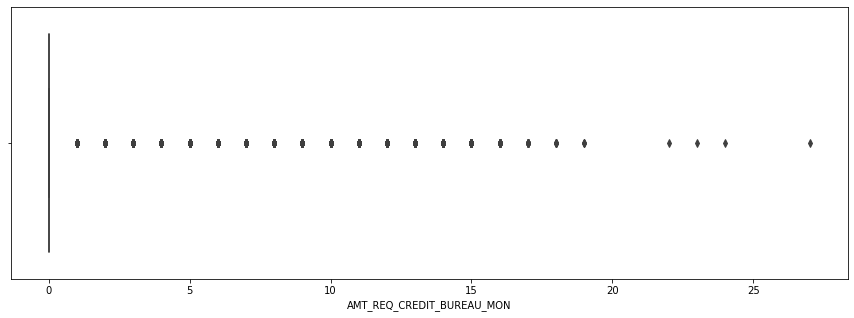

In [54]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=application_train_df['AMT_REQ_CREDIT_BUREAU_MON'])

In [52]:
application_train_df['AMT_REQ_CREDIT_BUREAU_MON'] = application_train_df['AMT_REQ_CREDIT_BUREAU_MON'].fillna(0)

In [26]:
#OBS_30_CNT_SOCIAL_CIRCLE

<AxesSubplot:xlabel='OBS_30_CNT_SOCIAL_CIRCLE'>

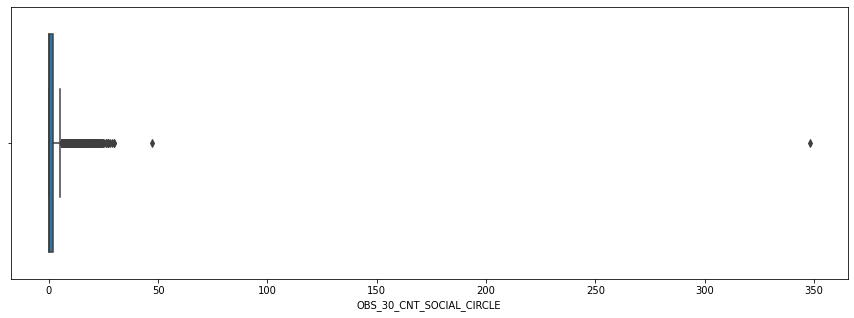

In [59]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=application_train_df['OBS_30_CNT_SOCIAL_CIRCLE'])

In [73]:
application_train_df['Column_check'] = pd.cut(application_train_df['OBS_30_CNT_SOCIAL_CIRCLE'], list(range(-1, 50, 5)) + [50, 700])
# Как ведет себя таргет в заисимости от значений признака
application_train_df.groupby('Column_check')['TARGET'].agg(['mean','sem','count'])

mean       sem   count
Column_check                            
(-1, 4]       0.080082  0.000515  277989
(4, 9]        0.086297  0.001763   25366
(9, 14]       0.093266  0.004882    3549
(14, 19]      0.069182  0.011631     477
(19, 24]      0.074766  0.025546     107
(24, 29]      0.047619  0.047619      21
(29, 34]      0.500000  0.500000       2
(34, 39]           NaN       NaN       0
(39, 44]           NaN       NaN       0
(44, 49]           NaN       NaN       0
(49, 50]           NaN       NaN       0
(50, 700]          NaN       NaN       0

In [79]:
application_train_df['OBS_30_CNT_SOCIAL_CIRCLE'] = make_nan(application_train_df, 'OBS_30_CNT_SOCIAL_CIRCLE', 34)

In [80]:
application_train_df['OBS_30_CNT_SOCIAL_CIRCLE'] = application_train_df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0)

<AxesSubplot:xlabel='OBS_60_CNT_SOCIAL_CIRCLE'>

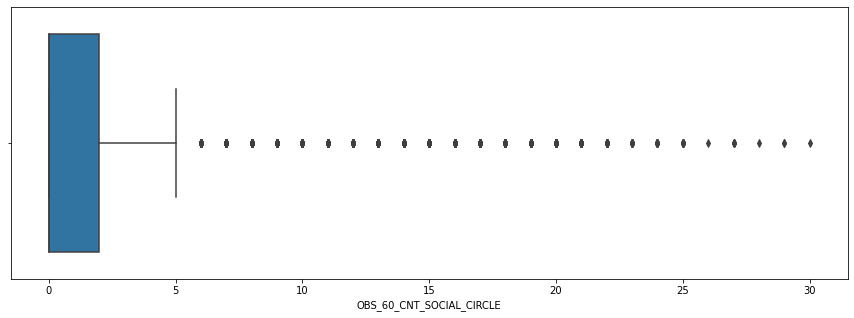

In [83]:
#OBS_60_CNT_SOCIAL_CIRCLE
plt.figure(figsize=(15, 5))
sns.boxplot(x=application_train_df['OBS_60_CNT_SOCIAL_CIRCLE'])

In [81]:
application_train_df['OBS_60_CNT_SOCIAL_CIRCLE'] = make_nan(application_train_df, 'OBS_60_CNT_SOCIAL_CIRCLE', 34)
application_train_df['OBS_60_CNT_SOCIAL_CIRCLE'] = application_train_df['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0)

In [82]:
application_train_df['Column_check'] = pd.cut(application_train_df['OBS_60_CNT_SOCIAL_CIRCLE'], list(range(-1, 50, 5)) + [50, 700])
# Как ведет себя таргет в заисимости от значений признака
application_train_df.groupby('Column_check')['TARGET'].agg(['mean','sem','count'])

mean       sem   count
Column_check                            
(-1, 4]       0.080079  0.000514  278486
(4, 9]        0.086517  0.001778   25001
(9, 14]       0.092684  0.004951    3431
(14, 19]      0.076759  0.012306     469
(19, 24]      0.048544  0.021279     103
(24, 29]      0.100000  0.068825      20
(29, 34]      0.000000       NaN       1
(34, 39]           NaN       NaN       0
(39, 44]           NaN       NaN       0
(44, 49]           NaN       NaN       0
(49, 50]           NaN       NaN       0
(50, 700]          NaN       NaN       0

71    Normalized information about building where th...
Name: Description, dtype: object
                 mean       sem   count
Column_check                           
(-1, 4]       0.06889  0.000682  137829
(4, 9]            NaN       NaN       0
(9, 14]           NaN       NaN       0
(14, 19]          NaN       NaN       0
(19, 24]          NaN       NaN       0
(24, 29]          NaN       NaN       0
(29, 34]          NaN       NaN       0
(34, 39]          NaN       NaN       0
(39, 44]          NaN       NaN       0
(44, 49]          NaN       NaN       0
Nans count 169682


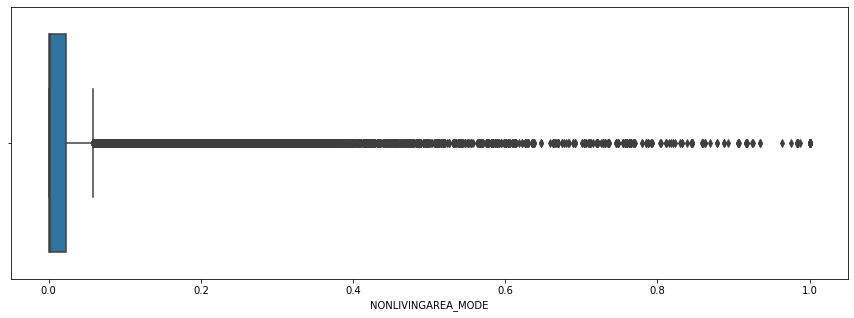

In [93]:
# NONLIVINGAREA_MODE
column_explain('NONLIVINGAREA_MODE')

10     For consumer loans it is the price of the good...
180    Goods price of good that client asked for (if ...
Name: Description, dtype: object
                      mean       sem  count
Column_check                               
(100000, 200000]  0.076890  0.001468  32956
(200000, 300000]  0.084176  0.001108  62761
(300000, 400000]  0.105094  0.002105  21219
(400000, 500000]  0.103457  0.001273  57251
(500000, 600000]  0.074560  0.002294  13117
(600000, 700000]  0.079377  0.001351  40024
(700000, 800000]  0.066338  0.002764   8110
(800000, 900000]  0.069587  0.001736  21484
Nans count 0


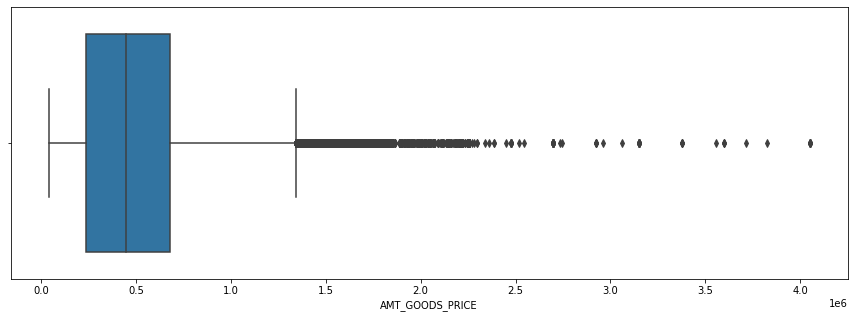

In [115]:
# AMT_GOODS_PRICE
column_explain('AMT_GOODS_PRICE', left = 100000, right = 1000000, step = 100000)
median = application_train_df.loc[application_train_df['AMT_GOODS_PRICE'].notnull()]['AMT_GOODS_PRICE'].median()
application_train_df['AMT_GOODS_PRICE'] = application_train_df['AMT_GOODS_PRICE'].fillna(median)

In [97]:
application_train_df['AMT_GOODS_PRICE']

0          351000.0
1         1129500.0
2          135000.0
3          297000.0
4          513000.0
            ...    
307506     225000.0
307507     225000.0
307508     585000.0
307509     319500.0
307510     675000.0
Name: AMT_GOODS_PRICE, Length: 307511, dtype: float64

7    Income of the client
Name: Description, dtype: object
                      mean       sem   count
Column_check                                
(0, 100000]       0.082028  0.001087   63698
(100000, 200000]  0.085479  0.000708  155898
(200000, 300000]  0.075503  0.001035   65176
(300000, 400000]  0.060303  0.001965   14676
(400000, 500000]  0.060063  0.003245    5361
(500000, 600000]  0.063014  0.007346    1095
(600000, 700000]  0.048331  0.007279     869
(700000, 800000]  0.018519  0.010625     162
(800000, 900000]  0.057047  0.013458     298
Nans count 0


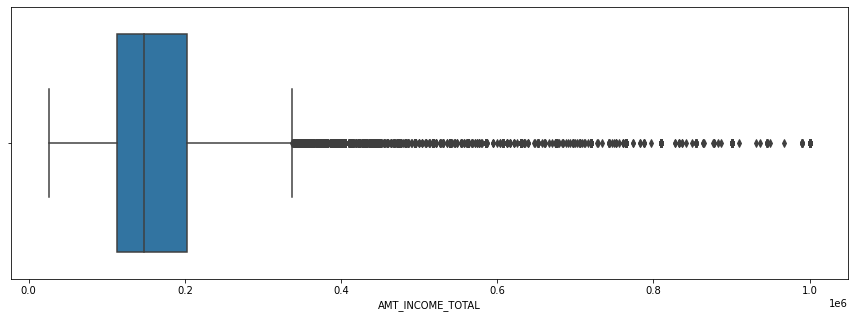

In [122]:
# AMT_INCOME_TOTAL
column_explain('AMT_INCOME_TOTAL', left = 0, right = 1000000, step = 100000)
application_train_df['AMT_INCOME_TOTAL'] = application_train_df['AMT_INCOME_TOTAL'].clip(0, 1000000)

95    How many days before application did client ch...
Name: Description, dtype: object
                 mean       sem  count
Column_check                          
(-1, 4]       0.09665  0.001522  37672
(4, 9]            NaN       NaN      0
(9, 14]           NaN       NaN      0
(14, 19]          NaN       NaN      0
(19, 24]          NaN       NaN      0
(24, 29]          NaN       NaN      0
(29, 34]          NaN       NaN      0
(34, 39]          NaN       NaN      0
(39, 44]          NaN       NaN      0
(44, 49]          NaN       NaN      0
Nans count 1


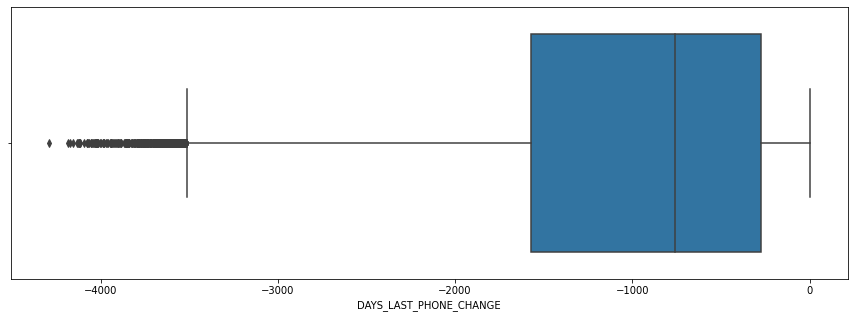

In [130]:
#DAYS_LAST_PHONE_CHANGE
column_explain('DAYS_LAST_PHONE_CHANGE')
application_train_df['DAYS_LAST_PHONE_CHANGE'] = application_train_df['DAYS_LAST_PHONE_CHANGE'].fillna(0)

29    How many family members does client have
Name: Description, dtype: object
                  mean       sem   count
Column_check                            
(-2, -1]           NaN       NaN       0
(-1, 0]            NaN       NaN       0
(0, 1]        0.083642  0.001063   67849
(1, 2]        0.075835  0.000665  158357
(2, 3]        0.087603  0.001233   52601
(3, 4]        0.086488  0.001789   24697
Nans count 0


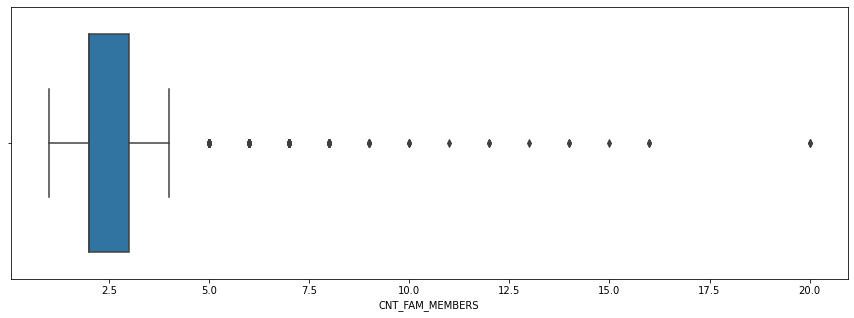

In [134]:
# CNT_FAM_MEMBERS
column_explain('CNT_FAM_MEMBERS', left = -2, right = 5, step = 1)
application_train_df['CNT_FAM_MEMBERS'] = application_train_df['CNT_FAM_MEMBERS'].fillna(1)

9                             Loan annuity
138    Annuity of the Credit Bureau credit
176        Annuity of previous application
Name: Description, dtype: object
                      mean       sem   count
Column_check                                
(-1, 24999]       0.079010  0.000685  154879
(24999, 49999]    0.086530  0.000776  131330
(49999, 74999]    0.059816  0.001706   19326
(74999, 99999]    0.039429  0.005076    1471
(99999, 124999]   0.020468  0.007668     342
(124999, 149999]  0.031579  0.018037      95
(149999, 174999]  0.000000  0.000000      24
(174999, 199999]  0.000000  0.000000       8
(199999, 224999]  0.000000  0.000000      11
(224999, 249999]  0.000000  0.000000      24
Nans count 0


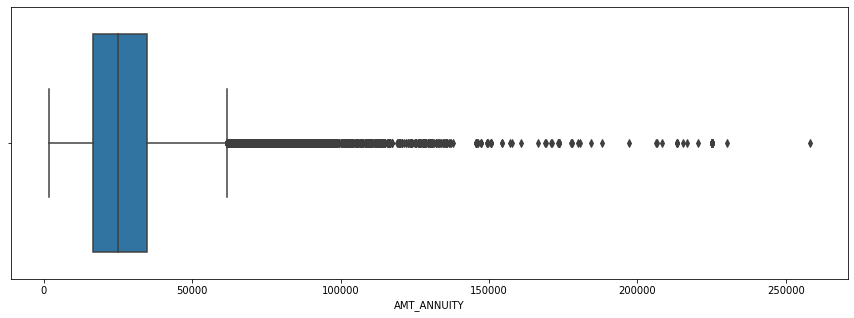

In [141]:
# AMT_ANNUITY
column_explain('AMT_ANNUITY', right = 250000, step = 25000)
application_train_df['AMT_ANNUITY'] = fill_median('AMT_ANNUITY')

92    How many observation of client's social surrou...
Name: Description, dtype: object
                  mean       sem   count
Column_check                            
(-1, 4]       0.080718  0.000491  307441
(4, 9]        0.130435  0.040841      69
(9, 14]            NaN       NaN       0
(14, 19]           NaN       NaN       0
(19, 24]           NaN       NaN       0
(24, 29]           NaN       NaN       0
(29, 34]      0.000000       NaN       1
(34, 39]           NaN       NaN       0
(39, 44]           NaN       NaN       0
(44, 49]           NaN       NaN       0
Nans count 0


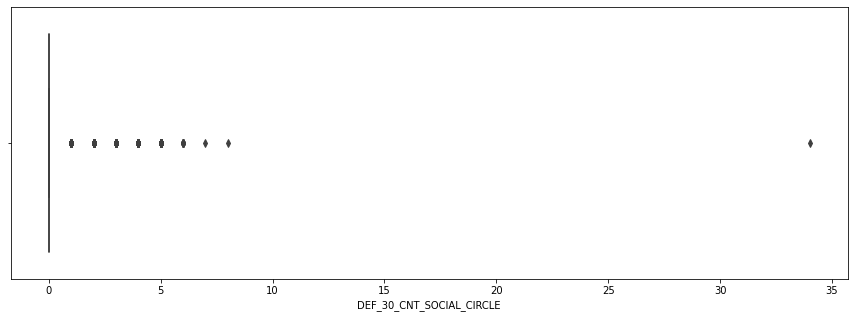

In [151]:
# DEF_30_CNT_SOCIAL_CIRCLE
column_explain('DEF_30_CNT_SOCIAL_CIRCLE')
application_train_df['DEF_30_CNT_SOCIAL_CIRCLE'] = application_train_df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)

94    How many observation of client's social surrou...
Name: Description, dtype: object
                  mean       sem   count
Column_check                            
(-1, 4]       0.080877  0.000493  306465
(4, 9]        0.125000  0.068960      24
(9, 14]            NaN       NaN       0
(14, 19]           NaN       NaN       0
(19, 24]      0.000000       NaN       1
(24, 29]           NaN       NaN       0
(29, 34]           NaN       NaN       0
(34, 39]           NaN       NaN       0
(39, 44]           NaN       NaN       0
(44, 49]           NaN       NaN       0
Nans count 1021


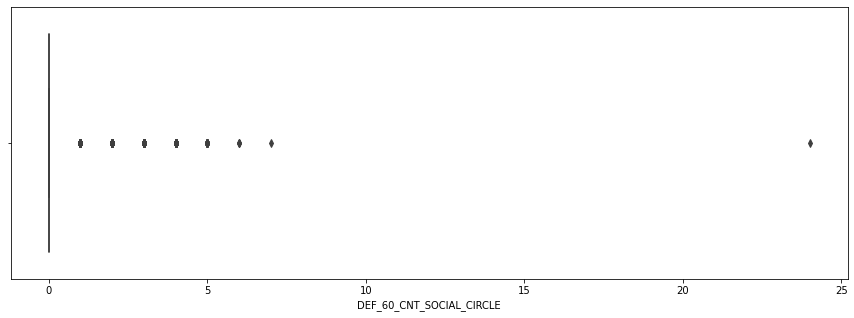

In [153]:
# DEF_60_CNT_SOCIAL_CIRCLE
column_explain('DEF_60_CNT_SOCIAL_CIRCLE')
application_train_df['DEF_60_CNT_SOCIAL_CIRCLE'] = application_train_df['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)

In [158]:
# NAME_TYPE_SUITE
application_train_df['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      249818
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [157]:
application_train_df['NAME_TYPE_SUITE'] = application_train_df['NAME_TYPE_SUITE'].fillna('Unaccompanied')

In [161]:
desc = 'Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor'

In [168]:
building_rows = description.loc[description['Description'] == desc]['Row']

In [176]:
# Не придумал что делать с этим огромным количеством признаков
# с характеристиками жилья, поэтому просто заполнил пропуски медианой
# проверил некоторые из признаков, особых аномалий не нашёл
for rows in building_rows:
    application_train_df[rows] = fill_median(rows)

Ошибка
Ошибка
Ошибка
Ошибка


In [177]:
application_train_df[building_rows]

APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0               0.0247            0.0369                       0.9722   
1               0.0959            0.0529                       0.9851   
2               0.0876            0.0763                       0.9816   
3               0.0876            0.0763                       0.9816   
4               0.0876            0.0763                       0.9816   
...                ...               ...                          ...   
307506          0.2021            0.0887                       0.9876   
307507          0.0247            0.0435                       0.9727   
307508          0.1031            0.0862                       0.9816   
307509          0.0124            0.0763                       0.9771   
307510          0.0742            0.0526                       0.9881   

        YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0                0.6192          0.0143           0.00         0.0690   
1                0.7960          0.0605           0.08         0.0345   
2                0.7552          0.0211           0.00         0.1379   
3                0.7552          0.0211           0.00         0.1379   
4                0.7552          0.0211           0.00         0.1379   
...                 ...             ...            ...            ...   
307506           0.8300          0.0202           0.22         0.1034   
307507           0.6260          0.0022           0.00         0.1034   
307508           0.7484          0.0123           0.00         0.2069   
307509           0.7552          0.0211           0.00         0.0690   
307510           0.7552          0.0176           0.08         0.0690   

        FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  ...  LANDAREA_MEDI  \
0              0.0833         0.1250        0.0369  ...         0.0375   
1              0.2917         0.3333        0.0130  ...         0.0132   
2              0.1667         0.2083        0.0481  ...         0.0487   
3              0.1667         0.2083        0.0481  ...         0.0487   
4              0.1667         0.2083        0.0481  ...         0.0487   
...               ...            ...           ...  ...            ...   
307506         0.6042         0.2708        0.0594  ...         0.0605   
307507         0.0833         0.1250        0.0579  ...         0.0589   
307508         0.1667         0.2083        0.0481  ...         0.0487   
307509         0.0417         0.2083        0.0481  ...         0.0487   
307510         0.3750         0.2083        0.0481  ...         0.0487   

        LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  \
0                      0.0205           0.0193                    0.0000   
1                      0.0787           0.0558                    0.0039   
2                      0.0761           0.0749                    0.0000   
3                      0.0761           0.0749                    0.0000   
4                      0.0761           0.0749                    0.0000   
...                       ...              ...                       ...   
307506                 0.1509           0.2001                    0.0757   
307507                 0.0205           0.0261                    0.0000   
307508                 0.0855           0.9445                    0.0000   
307509                 0.0761           0.0062                    0.0000   
307510                 0.0761           0.0805                    0.0000   

        NONLIVINGAREA_MEDI  FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0                   0.0000    reg oper account  block of flats   
1                   0.0100    reg oper account  block of flats   
2                   0.0031                 NaN             NaN   
3                   0.0031                 NaN             NaN   
4                   0.0031                 NaN             NaN   
...                    ...                 ...          

121    Number of enquiries to Credit Bureau about the...
Name: Description, dtype: object
                  mean       sem   count
Column_check                            
(-1, 4]       0.080065  0.000512  281259
(4, 9]        0.087817  0.001752   26111
(9, 14]       0.098214  0.028247     112
(14, 19]      0.041667  0.041667      24
(19, 24]      0.250000  0.250000       4
(24, 29]      0.000000       NaN       1
(29, 34]           NaN       NaN       0
(34, 39]           NaN       NaN       0
(39, 44]           NaN       NaN       0
(44, 49]           NaN       NaN       0
Nans count 0


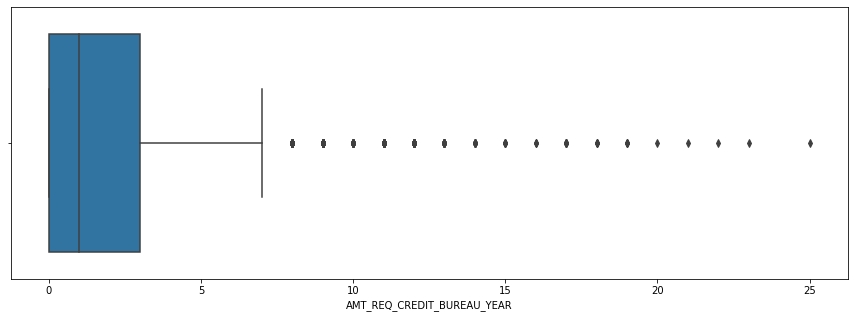

In [182]:
#AMT_REQ_CREDIT_BUREAU_YEAR
column_explain('AMT_REQ_CREDIT_BUREAU_YEAR')
application_train_df['AMT_REQ_CREDIT_BUREAU_YEAR'] = application_train_df['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(0)

In [183]:
#Посчитал, что если количество запросов NaN, то этих запросов и не было,
#поэтому заполнил нулями
amt_columns = ['AMT_REQ_CREDIT_BUREAU_YEAR',
               'AMT_REQ_CREDIT_BUREAU_WEEK',
               'AMT_REQ_CREDIT_BUREAU_DAY',
               'AMT_REQ_CREDIT_BUREAU_HOUR']

121    Number of enquiries to Credit Bureau about the...
Name: Description, dtype: object
                  mean       sem   count
Column_check                            
(-2, -1]           NaN       NaN       0
(-1, 0]       0.083083  0.000820  113320
(0, 1]        0.073338  0.001035   63405
(1, 2]        0.081049  0.001218   50192
(2, 3]        0.079577  0.001476   33628
(3, 4]        0.082553  0.001912   20714
Nans count 0
118    Number of enquiries to Credit Bureau about the...
Name: Description, dtype: object
                  mean       sem   count
Column_check                            
(-2, -1]           NaN       NaN       0
(-1, 0]       0.077159  0.000526  257456
(0, 1]        0.077729  0.002955    8208
(1, 2]        0.100503  0.021368     199
(2, 3]        0.068966  0.033563      58
(3, 4]        0.117647  0.056086      34
Nans count 41519
117    Number of enquiries to Credit Bureau about the...
Name: Description, dtype: object
                  mean       sem   count
Col

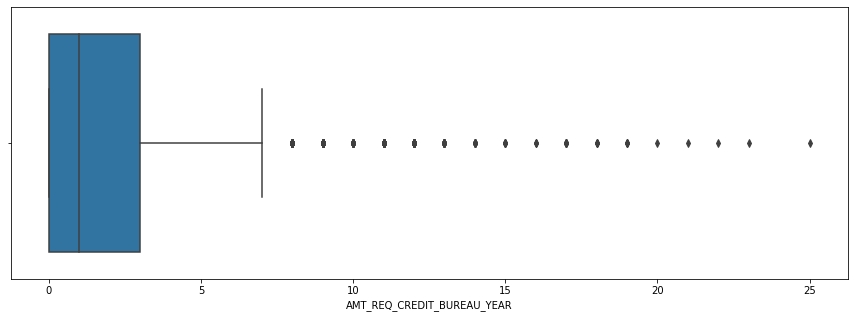

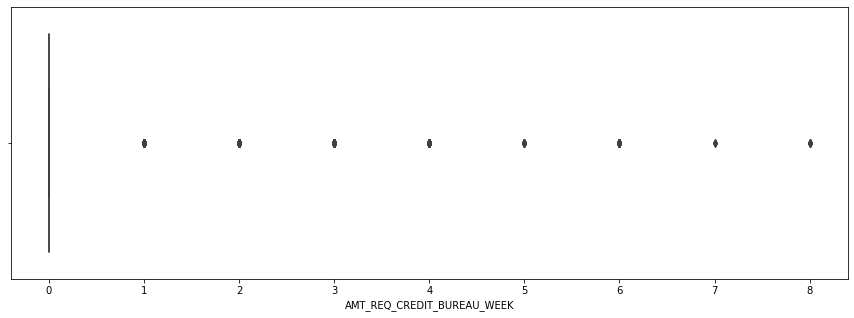

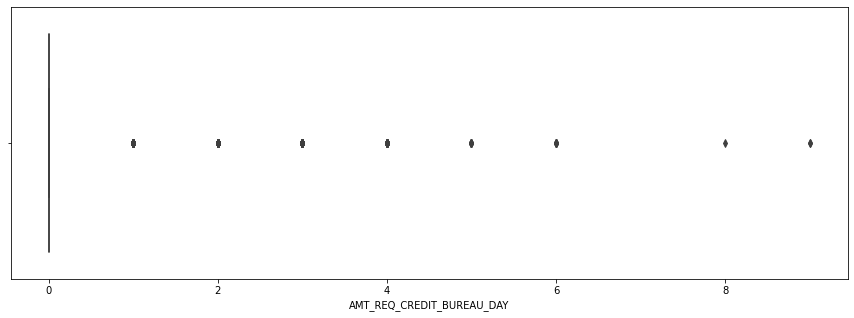

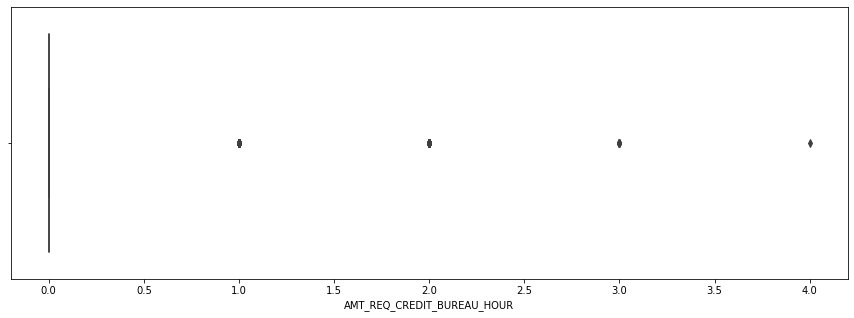

In [185]:
for columns in amt_columns:
    column_explain(columns, left = -2, right = 5, step = 1)

In [186]:
for columns in amt_columns:
    application_train_df[columns] = application_train_df[columns].fillna(0)

In [189]:
# Описывается как скор из внешнего источника, не знаю что за признак, поэтому заполню медианой
sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
for columns in sources:
    application_train_df[columns] = fill_median(columns)

In [192]:
# OCCUPATION_TYPE
application_train_df['OCCUPATION_TYPE']

0            Laborers
1          Core staff
2            Laborers
3            Laborers
4          Core staff
             ...     
307506    Sales staff
307507            NaN
307508       Managers
307509       Laborers
307510       Laborers
Name: OCCUPATION_TYPE, Length: 307511, dtype: object

In [207]:
# EMERGENCYSTATE_MODE
application_train_df['EMERGENCYSTATE_MODE'].value_counts()
application_train_df['EMERGENCYSTATE_MODE'] = application_train_df['EMERGENCYSTATE_MODE'].fillna('No')

In [208]:
# HOUSETYPE_MODE
application_train_df['HOUSETYPE_MODE'].value_counts()
application_train_df['HOUSETYPE_MODE'] = application_train_df['HOUSETYPE_MODE'].fillna('block of flats')

In [211]:
# WALLSMATERIAL_MODE
application_train_df['WALLSMATERIAL_MODE'].value_counts()
application_train_df['WALLSMATERIAL_MODE'] = application_train_df['WALLSMATERIAL_MODE'].fillna('Panel')

In [209]:
# FONDKAPREMONT_MODE
application_train_df['FONDKAPREMONT_MODE'].value_counts()
application_train_df['FONDKAPREMONT_MODE'] = application_train_df['FONDKAPREMONT_MODE'].fillna('reg oper account ')

In [212]:
# OWN_CAR_AGE
application_train_df['OWN_CAR_AGE'].value_counts()

7.0     7424
6.0     6382
3.0     6370
8.0     5887
2.0     5852
        ... 
69.0       1
50.0       1
47.0       1
48.0       1
52.0       1
Name: OWN_CAR_AGE, Length: 62, dtype: int64

In [218]:
application_train_df.loc[application_train_df['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE'] = 0
application_train_df.loc[application_train_df['FLAG_OWN_CAR'] == 'Y', 'OWN_CAR_AGE'] = 1

In [215]:
application_train_df['FLAG_OWN_CAR']

0         N
1         N
2         Y
3         N
4         N
         ..
307506    N
307507    N
307508    N
307509    N
307510    N
Name: FLAG_OWN_CAR, Length: 307511, dtype: object

In [220]:
# Найдем все категориальные признаки
categorical_columns = [c for c in application_train_df.columns if application_train_df[c].dtype in ['object']]
print(categorical_columns)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [230]:
# Заполним пропуски самыми простым способом: наиболее частотной категорией
for col in categorical_columns:
    mode = application_train_df[col].mode().iloc[0]
    application_train_df[col] = application_train_df[col].fillna(mode)

In [221]:
# Обучим энкодер
categorical_features_le = pd.DataFrame()
for col in categorical_columns:
    le = LabelEncoder()
    application_train_df[f'{col}_le'] = le.fit_transform(application_train_df[col])

In [222]:
application_train_df.groupby('NAME_EDUCATION_TYPE_le')['TARGET'].mean()

NAME_EDUCATION_TYPE_le
0    0.018293
1    0.053551
2    0.084850
3    0.109277
4    0.089399
Name: TARGET, dtype: float64

In [223]:
# Для признаков, категории которых поддаются сравнению, можно бороться с этой проблемой с помощью OrdinalEncoder, но порядок придется задавать самому
oe = OrdinalEncoder(categories = [['Lower secondary','Secondary / secondary special', 'Incomplete higher', 'Higher education','Academic degree']])
application_train_df['NAME_EDUCATION_TYPE_oe'] = oe.fit_transform(application_train_df[['NAME_EDUCATION_TYPE']])

In [224]:
application_train_df.groupby('NAME_EDUCATION_TYPE_oe')['TARGET'].mean()

NAME_EDUCATION_TYPE_oe
0.0    0.109277
1.0    0.089399
2.0    0.084850
3.0    0.053551
4.0    0.018293
Name: TARGET, dtype: float64

In [244]:
application_train_df.groupby('OCCUPATION_TYPE')['TARGET'].mean().sort_values().index.values

array(['Accountants', 'High skill tech staff', 'Managers', 'Core staff',
       'HR staff', 'IT staff', 'Private service staff', 'Medicine staff',
       'Secretaries', 'Realty agents', 'Laborers', 'Cleaning staff',
       'Sales staff', 'Cooking staff', 'Security staff',
       'Waiters/barmen staff', 'Drivers', 'Low-skill Laborers'],
      dtype=object)

In [262]:
def encoding(df, column):
    '''
    Сортирует фичи по влиянию на таргет и обучает OE для энкодинга
    '''
    df_encoded = df.copy()
    value = list(map(str, df_encoded.groupby(column)['TARGET'].mean().sort_values().index.values))
    oe = OrdinalEncoder(categories = [value])
    df_encoded[column] = oe.fit_transform(df_encoded[[column]])
    return df_encoded[column]

In [261]:
list(map(str, application_train_df.groupby('NAME_CONTRACT_TYPE')['TARGET'].mean().sort_values().index.values))

['1', '0']

In [263]:
application_train_df['NAME_CONTRACT_TYPE'] = encoding(application_train_df, 'NAME_CONTRACT_TYPE')

ValueError: Unsorted categories are not supported for numerical categories

In [ ]:
# Обучим энкодер
categorical_features_le = pd.DataFrame()
for col in categorical_columns:
    application_train_df[col] = encoding(application_train_df, col)

In [232]:
for_le =['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
for col in for_le:
    le = LabelEncoder()
    application_train_df[col] = le.fit_transform(application_train_df[col])

In [ ]:
# CODE_GENDER
oe = OrdinalEncoder(categories = [['XNA','F', 'M']])
application_train_df['CODE_GENDER'] = oe.fit_transform(application_train_df[['CODE_GENDER']])
# NAME_EDUCATION_TYPE
oe = OrdinalEncoder(categories = [['Lower secondary','Secondary / secondary special', 'Incomplete higher', 'Higher education','Academic degree']])
application_train_df['NAME_EDUCATION_TYPE'] = oe.fit_transform(application_train_df[['NAME_EDUCATION_TYPE']])
# NAME_TYPE_SUITE
oe = OrdinalEncoder(categories = [['Lower secondary','Secondary / secondary special', 'Incomplete higher', 'Higher education','Academic degree']])
application_train_df['NAME_TYPE_SUITE'] = oe.fit_transform(application_train_df[['NAME_TYPE_SUITE']])